# Classification

Notebook for classification tasks

Plan:
- Load data
- Train/test split
- Baseline model (Logistic Regression)
- Metrics: accuracy, precision, recall, F1, ROC-AUC


In [86]:
# Я начинаю проект: подключаю базовые библиотеки
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    roc_auc_score,
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay
)

In [87]:
# Загружаю train.csv
df = pd.read_csv("train.csv")

# Смотрю размер (строки, столбцы)
print("Размер df:", df.shape)

# Смотрю первые строки
df.head()

Размер df: (436968, 59)


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9.0,1.0,5.0,8.0,0.0,1.0,1.0,0.0,0.0,1.0
1,9,0,1,1,7,0,0,0,0,1,...,3.0,1.0,1.0,9.0,0.0,1.0,1.0,0.0,1.0,0.0
2,13,0,5,4,9,1,0,0,0,1,...,4.0,2.0,7.0,7.0,0.0,1.0,1.0,0.0,1.0,0.0
3,16,0,0,1,2,0,0,1,0,0,...,2.0,2.0,4.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,0,0,2,0,1,0,1,0,0,...,3.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0


In [88]:
# Смотрю распределение целевого признака (сколько 0 и 1)
print(df["target"].value_counts())

# Смотрю доли, чтобы понять дисбаланс
print(df["target"].value_counts(normalize=True))


target
0    421037
1     15931
Name: count, dtype: int64
target
0    0.963542
1    0.036458
Name: proportion, dtype: float64


In [89]:
# Считаю, сколько -1 в каждом столбце (пропусков)
minus_ones = (df == -1).sum().sort_values(ascending=False)

# Покажу 10 столбцов с наибольшим количеством -1
print(minus_ones.head(10))


ps_car_03_cat    301867
ps_car_05_cat    195692
ps_reg_03         79253
ps_car_14         31237
ps_car_07_cat      8350
ps_ind_05_cat      4264
ps_car_09_cat       412
ps_ind_02_cat       151
ps_car_01_cat        78
ps_ind_04_cat        59
dtype: int64


In [90]:
# Удаляю столбец с огромным количеством пропусков
df = df.drop(columns=['ps_car_03_cat'])

print("Размер после удаления ps_car_03_cat:", df.shape)

Размер после удаления ps_car_03_cat: (436968, 58)


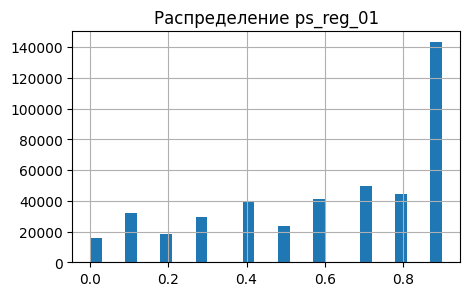

In [91]:
import matplotlib.pyplot as plt

# пример числового признака
col_num = "ps_reg_01"

plt.figure(figsize=(5,3))
df[col_num].replace(-1, None).dropna().hist(bins=30)
plt.title(f"Распределение {col_num}")
plt.show()


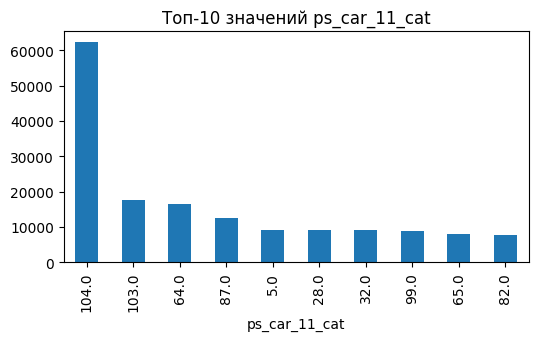

In [92]:
col_cat = "ps_car_11_cat"

vc = df[col_cat].replace(-1, None).dropna().value_counts().head(10)

plt.figure(figsize=(6,3))
vc.plot(kind="bar")
plt.title(f"Топ-10 значений {col_cat}")
plt.show()


In [93]:
# Временно заменяем -1 на NaN, чтобы корреляция считалась корректно
df_corr = df.replace(-1, np.nan)

# Берем только числовые столбцы
corr = df_corr.corr(numeric_only=True)

# Корреляция с target
corr_target = corr["target"].abs().sort_values(ascending=False)

print("Топ-10 признаков по |корреляции| с target:")
print(corr_target.iloc[1:11])  # первый — это сам target


Топ-10 признаков по |корреляции| с target:
ps_car_13        0.055436
ps_car_12        0.038905
ps_ind_17_bin    0.037939
ps_reg_02        0.034665
ps_ind_06_bin    0.034068
ps_car_04_cat    0.033959
ps_ind_07_bin    0.033813
ps_reg_03        0.033431
ps_ind_05_cat    0.031723
ps_car_02_cat    0.030860
Name: target, dtype: float64


In [94]:
# id — это просто идентификатор строки, модели он не помогает, удалим
if "id" in df.columns:
 df = df.drop(columns=["id"])



Этап 1 завершили, переходим ко второму. Анонимизация лишает нас понимания смысла признаков, pначение -1, если его не обработать, воспринимается деревом как обычное число

In [95]:
# Заменяем -1 на NaN
df = df.replace(-1, np.nan)


In [96]:
# Признаки (всё кроме target)
X = df.drop(columns=['target'])

# Цель
y = df['target']

# Делим на train и valid, чтобы доля единиц сохранилась (из-за дисбаланса)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("train:", X_train.shape, "valid:", X_valid.shape)
print("Доля класса 1 в train:", y_train.mean())
print("Доля класса 1 в valid:", y_valid.mean())

train: (349574, 56) valid: (87394, 56)
Доля класса 1 в train: 0.036458661113240684
Доля класса 1 в valid: 0.036455591917065246


Данные подготовлены, перехожу к обучению.

In [97]:
# Заполняем NaN отдельно для train и valid медианой
for col in X_train.columns:
    if X_train[col].dtype in ["float64", "int64"]:
        median = X_train[col].median()
        X_train[col] = X_train[col].fillna(median)
        X_valid[col] = X_valid[col].fillna(median)


In [98]:
# Обучаю логистическую регрессию
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=2000,
    n_jobs=-1,
    random_state=42
)

lr_model.fit(X_train, y_train)
print("Логистическая регрессия обучена ✔")



Логистическая регрессия обучена ✔


In [99]:
# Предсказываем вероятности класса 1 на валидации
y_valid_proba = lr_model.predict_proba(X_valid)[:, 1]

# Считаем метрики качества
auc = roc_auc_score(y_valid, y_valid_proba)
gini = 2 * auc - 1

print(f"ROC-AUC: {auc:.5f}")
print(f"Gini: {gini:.5f}")



ROC-AUC: 0.61976
Gini: 0.23952


In [100]:
# Преобразуем вероятности в метки при пороге 0.5
y_valid_pred = (y_valid_proba >= 0.5).astype(int)
# Вычисляем Precision, Recall, F1 для класса 1
precision = precision_score(y_valid, y_valid_pred, zero_division=0)
recall = recall_score(y_valid, y_valid_pred, zero_division=0)
f1 = f1_score(y_valid, y_valid_pred, zero_division=0)
print(f"Precision (class=1): {precision:.5f}")
print(f"Recall (class=1): {recall:.5f}")
print(f"F1-score (class=1): {f1:.5f}")


Precision (class=1): 0.05250
Recall (class=1): 0.54708
F1-score (class=1): 0.09580


Confusion Matrix:
[[52750 31458]
 [ 1443  1743]]


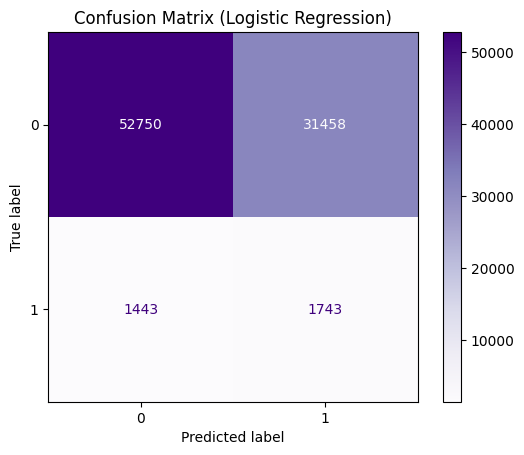

In [101]:
# Матрица ошибок на валидации
cm = confusion_matrix(y_valid, y_valid_pred)
print("Confusion Matrix:")
print(cm)
2
# Визуализируем матрицу ошибок в виде графика
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Purples')
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

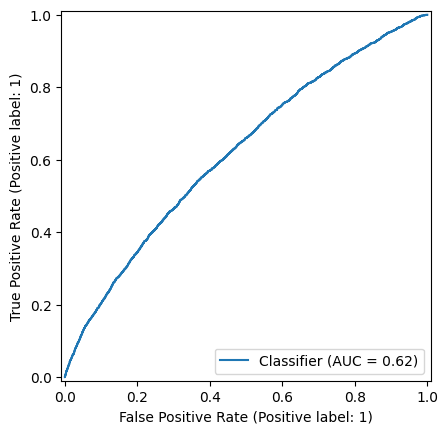

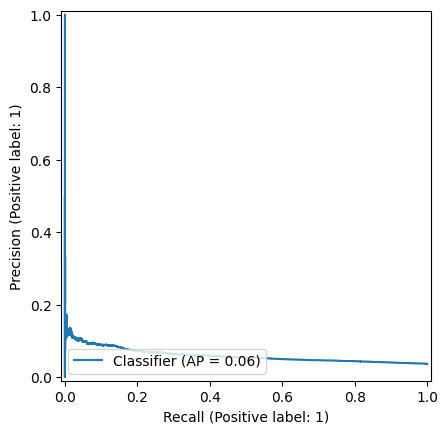

In [102]:
RocCurveDisplay.from_predictions(y_valid, y_valid_proba)
PrecisionRecallDisplay.from_predictions(y_valid, y_valid_proba)


Этап 3 закончил, перехожу к этапу 4

In [103]:
import time
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

def gini_from_auc(auc: float) -> float:
    return 2 * auc - 1

def eval_model(name, model, X_tr, y_tr, X_va, y_va, threshold=0.5):
    t0 = time.perf_counter()

    model.fit(X_tr, y_tr)
    fit_time = time.perf_counter() - t0

    y_va_proba = model.predict_proba(X_va)[:, 1]
    auc = roc_auc_score(y_va, y_va_proba)
    gini = gini_from_auc(auc)

    y_va_pred = (y_va_proba >= threshold).astype(int)
    f1 = f1_score(y_va, y_va_pred, zero_division=0)

    return {
        "model": name,
        "AUC": auc,
        "Gini": gini,
        "F1@0.5": f1,
        "fit_time_sec": fit_time
    }


In [104]:
t0 = time.perf_counter()

TUNE_SIZE = 50000
tune_size = min(TUNE_SIZE, len(X_train))

X_tune, _, y_tune, _ = train_test_split(
    X_train, y_train,
    train_size=tune_size,
    random_state=42,
    stratify=y_train
)

print("X_tune:", X_tune.shape, "y_tune mean:", y_tune.mean())
print("Time:", round(time.perf_counter() - t0, 3), "sec")


X_tune: (50000, 56) y_tune mean: 0.03646
Time: 0.403 sec


In [105]:
t0 = time.perf_counter()

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_base = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

param_dist = {
    "n_estimators": [200, 300],
    "max_depth": [6, 8, 10, None],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", 0.5, 0.7]
}

rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=6,
    scoring="roc_auc",
    cv=2,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_search.fit(X_tune, y_tune)

print("Best RF params:", rf_search.best_params_)
print("Best RF AUC (CV):", rf_search.best_score_)
print("Time:", round(time.perf_counter() - t0, 3), "sec")


Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best RF params: {'n_estimators': 200, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 6}
Best RF AUC (CV): 0.6043121942760235
Time: 161.536 sec


In [106]:
t0 = time.perf_counter()

rf_best = RandomForestClassifier(
    **rf_search.best_params_,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_res = eval_model("RandomForest", rf_best, X_train, y_train, X_valid, y_valid)
print(rf_res)
print("Total cell time:", round(time.perf_counter() - t0, 3), "sec")

{'model': 'RandomForest', 'AUC': np.float64(0.6222437879586482), 'Gini': np.float64(0.24448757591729642), 'F1@0.5': 0.09535668825059494, 'fit_time_sec': 70.99590294900008}
Total cell time: 72.091 sec


In [107]:
!pip install -q lightgbm optuna

In [108]:
optuna.logging.set_verbosity(optuna.logging.WARNING)  # чтобы Optuna не спамила

t0 = time.perf_counter()

# дисбаланс
pos = int(y_train.sum())
neg = int(len(y_train) - pos)
scale_pos_weight = neg / max(pos, 1)

# внутренний split внутри tune для Optuna (быстро)
X_t_tr, X_t_va, y_t_tr, y_t_va = train_test_split(
    X_tune, y_tune, test_size=0.2, random_state=42, stratify=y_tune
)

def objective(trial):
    params = {
        "n_estimators": 4000,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 96),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 80),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 2.0),
        "random_state": 42,
        "n_jobs": -1,
        "scale_pos_weight": scale_pos_weight,
        "force_row_wise": True,
        "verbose": -1,  # ← убираем спам
    }

    model = LGBMClassifier(**params)
    model.fit(
        X_t_tr, y_t_tr,
        eval_set=[(X_t_va, y_t_va)],
        eval_metric="auc",
        callbacks=[
            lgb.early_stopping(100, verbose=False),
            lgb.log_evaluation(0)  # ← убираем вывод
        ]
    )
    proba = model.predict_proba(X_t_va)[:, 1]
    return roc_auc_score(y_t_va, proba)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=12)  # если долго → 8

print("Best tune AUC:", study.best_value)
print("Best params:", study.best_params)
print("Time:", round(time.perf_counter() - t0, 3), "sec")


Best tune AUC: 0.5843858364552751
Best params: {'learning_rate': 0.09217777892634564, 'num_leaves': 16, 'max_depth': 7, 'min_child_samples': 79, 'subsample': 0.9954113800489117, 'colsample_bytree': 0.7884889623413088, 'reg_alpha': 0.9826789938443682, 'reg_lambda': 0.061131494687071464}
Time: 13.917 sec


In [109]:
t0 = time.perf_counter()

best_params = study.best_params.copy()

lgbm_best = LGBMClassifier(
    n_estimators=6000,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    force_row_wise=True,
    verbose=-1,                 # ← убираем спам
    **best_params
)

lgbm_best.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="auc",
    callbacks=[
        lgb.early_stopping(200, verbose=False),
        lgb.log_evaluation(0)   # ← убираем вывод
    ]
)

# вероятности на valid
y_valid_proba_lgb = lgbm_best.predict_proba(X_valid)[:, 1]

# AUC / Gini
auc_lgb = roc_auc_score(y_valid, y_valid_proba_lgb)
gini_lgb = 2 * auc_lgb - 1

# F1 при 0.5 (как в задании)
f1_lgb_05 = f1_score(y_valid, (y_valid_proba_lgb >= 0.5).astype(int), zero_division=0)

# Подбор порога под лучший F1 (чтобы не было F1=0)
thr_grid = np.linspace(0.01, 0.5, 60)
best_thr, best_f1 = 0.5, -1
for thr in thr_grid:
    f1 = f1_score(y_valid, (y_valid_proba_lgb >= thr).astype(int), zero_division=0)
    if f1 > best_f1:
        best_f1, best_thr = f1, thr

lgb_res = {
    "model": "LightGBM",
    "AUC": float(auc_lgb),
    "Gini": float(gini_lgb),
    "F1@0.5": float(f1_lgb_05),
    "BestThr(F1)": float(best_thr),
    "BestF1": float(best_f1),
    "fit_time_sec": round(time.perf_counter() - t0, 6)
}
print(lgb_res)


{'model': 'LightGBM', 'AUC': 0.6037783171709212, 'Gini': 0.20755663434184246, 'F1@0.5': 0.0, 'BestThr(F1)': 0.12627118644067795, 'BestF1': 0.1024688080700823, 'fit_time_sec': 13.719026}


In [110]:
t0 = time.perf_counter()

# Базовые модели (с лучшими настройками)
rf_stack = RandomForestClassifier(
    **rf_search.best_params_,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

lgb_stack = LGBMClassifier(
    n_estimators=4000,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    force_row_wise=True,
    verbose=-1,            # ← убираем спам
    **study.best_params
)

# OOF предсказания на tune
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

oof_rf = np.zeros(len(X_tune))
oof_lgb = np.zeros(len(X_tune))

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_tune, y_tune), 1):
    X_tr_f, X_va_f = X_tune.iloc[tr_idx], X_tune.iloc[va_idx]
    y_tr_f, y_va_f = y_tune.iloc[tr_idx], y_tune.iloc[va_idx]

    rf_stack.fit(X_tr_f, y_tr_f)
    oof_rf[va_idx] = rf_stack.predict_proba(X_va_f)[:, 1]

    lgb_stack.fit(
        X_tr_f, y_tr_f,
        eval_set=[(X_va_f, y_va_f)],
        eval_metric="auc",
        callbacks=[
            lgb.early_stopping(100, verbose=False),
            lgb.log_evaluation(0)  # ← убираем вывод
        ]
    )
    oof_lgb[va_idx] = lgb_stack.predict_proba(X_va_f)[:, 1]

# meta-модель обучаем на двух признаках: (proba_RF, proba_LGB)
X_meta = np.column_stack([oof_rf, oof_lgb])

meta_model = LogisticRegression(max_iter=2000, n_jobs=-1, random_state=42)
meta_model.fit(X_meta, y_tune)

print("Meta-model trained on OOF ✔")
print("Time:", round(time.perf_counter() - t0, 3), "sec")


Meta-model trained on OOF ✔
Time: 18.452 sec


In [111]:
t0 = time.perf_counter()

# 1) дообучаем базовые модели на полном train
rf_stack.fit(X_train, y_train)
lgb_stack.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="auc",
    callbacks=[
        lgb.early_stopping(200, verbose=False),
        lgb.log_evaluation(0)
    ]
)

# 2) получаем два прогноза на valid
rf_va = rf_stack.predict_proba(X_valid)[:, 1]
lgb_va = lgb_stack.predict_proba(X_valid)[:, 1]

# 3) мета-модель делает финальную вероятность
X_meta_valid = np.column_stack([rf_va, lgb_va])
stack_proba = meta_model.predict_proba(X_meta_valid)[:, 1]

# метрики
auc_stack = roc_auc_score(y_valid, stack_proba)
gini_stack = 2 * auc_stack - 1
f1_stack_05 = f1_score(y_valid, (stack_proba >= 0.5).astype(int), zero_division=0)

# лучший порог под F1
thr_grid = np.linspace(0.01, 0.5, 60)
best_thr, best_f1 = 0.5, -1
for thr in thr_grid:
    f1 = f1_score(y_valid, (stack_proba >= thr).astype(int), zero_division=0)
    if f1 > best_f1:
        best_f1, best_thr = f1, thr

stack_res = {
    "model": "Stacking(RF+LGBM→LR)",
    "AUC": float(auc_stack),
    "Gini": float(gini_stack),
    "F1@0.5": float(f1_stack_05),
    "BestThr(F1)": float(best_thr),
    "BestF1": float(best_f1),
    "fit_time_sec": round(time.perf_counter() - t0, 6)
}
print(stack_res)


{'model': 'Stacking(RF+LGBM→LR)', 'AUC': 0.6222977526190192, 'Gini': 0.2445955052380384, 'F1@0.5': 0.0, 'BestThr(F1)': 0.059830508474576265, 'BestF1': 0.10781560380848003, 'fit_time_sec': 84.889874}


In [112]:
results = pd.DataFrame([rf_res, lgb_res, stack_res]).sort_values("Gini", ascending=False)
results


,model,AUC,Gini,F1@0.5,fit_time_sec,BestThr(F1),BestF1
2,Stacking(RF+LGBM→LR),0.622298,0.244596,0.000000,84.889874,0.059831,0.107816
0,RandomForest,0.622244,0.244488,0.095357,70.995903,NaN,NaN
1,LightGBM,0.603778,0.207557,0.000000,13.719026,0.126271,0.102469


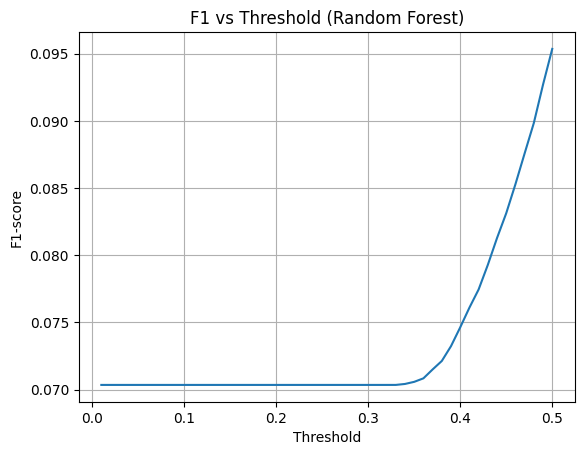

Лучший порог: 0.500, F1 = 0.0954


In [113]:
y_proba = rf_best.predict_proba(X_valid)[:, 1]

thresholds = np.linspace(0.01, 0.5, 50)
f1_scores = [f1_score(y_valid, (y_proba >= thr).astype(int), zero_division=0)
             for thr in thresholds]

best_thr = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

plt.plot(thresholds, f1_scores)
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("F1 vs Threshold (Random Forest)")
plt.grid(True)
plt.show()

print(f"Лучший порог: {best_thr:.3f}, F1 = {best_f1:.4f}")